#### Importating Necessary Libraries

In [0]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from pyspark.sql.functions import col, explode
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.feature import RFormula
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
mlflow.pyspark.ml.autolog()

#### Creating SparkSession And Loading Dataset Into A Spark DataFrame

In [0]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Steam Recommender System") \
    .getOrCreate()

In [0]:
# Load the dataset into a Spark DataFrame with header and inferring schema
steam_df = spark.read.csv("dbfs:/FileStore/tables/steam_200k.csv", header=True, inferSchema=True) \
                .toDF("UserID", "game_name", "User_Behavior", "Hours_Played")


In [0]:
# Show the schema and first few rows of the DataFrame
steam_df.printSchema()
steam_df.show(5)


root
 |-- UserID: integer (nullable = true)
 |-- game_name: string (nullable = true)
 |-- User_Behavior: string (nullable = true)
 |-- Hours_Played: double (nullable = true)

+---------+--------------------+-------------+------------+
|   UserID|           game_name|User_Behavior|Hours_Played|
+---------+--------------------+-------------+------------+
|151603712|The Elder Scrolls...|         play|       273.0|
|151603712|           Fallout 4|     purchase|         1.0|
|151603712|           Fallout 4|         play|        87.0|
|151603712|               Spore|     purchase|         1.0|
|151603712|               Spore|         play|        14.9|
+---------+--------------------+-------------+------------+
only showing top 5 rows



In [0]:
# Summary statistics of numerical columns
print("Summary statistics of numerical columns:")
steam_df.describe().show()

Summary statistics of numerical columns:
+-------+--------------------+----------------+-------------+------------------+
|summary|              UserID|       game_name|User_Behavior|      Hours_Played|
+-------+--------------------+----------------+-------------+------------------+
|  count|              199999|          199999|       199999|            199999|
|   mean|1.0365562620621103E8|           140.0|         NULL|17.874468372341777|
| stddev|  7.20808355946763E7|             0.0|         NULL| 138.0572916399091|
|    min|                5250|     007 Legends|         play|               0.1|
|    max|           309903146|theHunter Primal|     purchase|           11754.0|
+-------+--------------------+----------------+-------------+------------------+



In [0]:
# Filter the dataset to include only 'play' behavior
play_data = steam_df.filter(steam_df['User_Behavior'] == 'play').select('Hours_Played')


In [0]:
# Show 5 play_data
play_data.show(5)

+------------+
|Hours_Played|
+------------+
|       273.0|
|        87.0|
|        14.9|
|        12.1|
|         8.9|
+------------+
only showing top 5 rows



#### Data Exploration

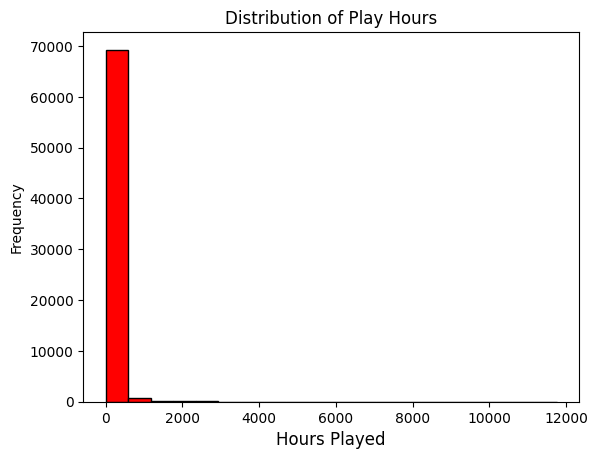

In [0]:
# Histogram of play hours
plt.hist(play_data.toPandas()['Hours_Played'], bins=20, color='red', edgecolor='black')
plt.xlabel('Hours Played', fontsize=12)
plt.ylabel('Frequency')
plt.title('Distribution of Play Hours')
plt.show()

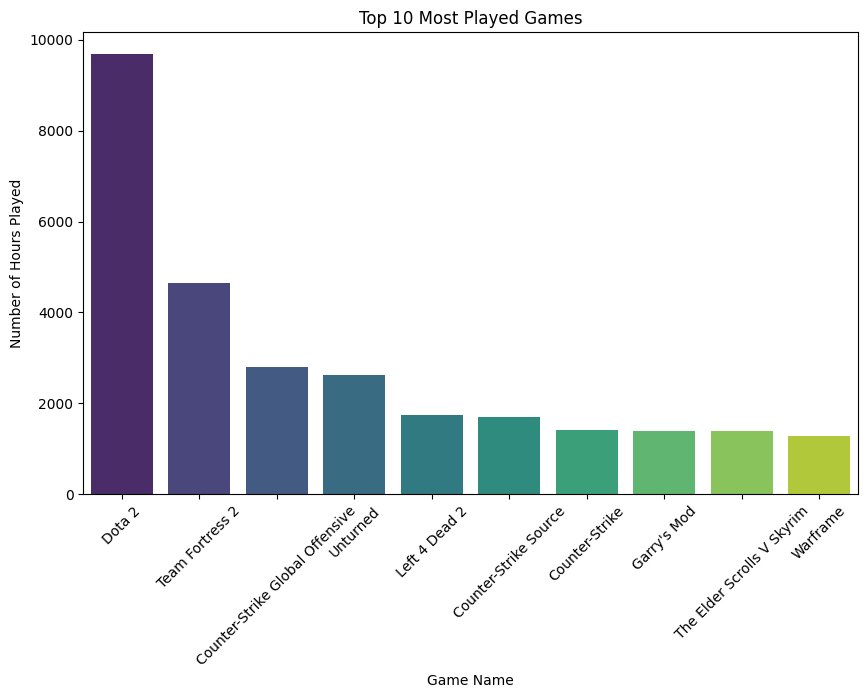

In [0]:
# Top N Games Played
top_n = 10
top_games = steam_df.groupBy('Game_Name').count().orderBy('count', ascending=False).limit(top_n).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Game_Name', y='count', data=top_games, palette='viridis')
plt.xlabel('Game Name')
plt.ylabel('Number of Hours Played')
plt.title(f'Top {top_n} Most Played Games')
plt.xticks(rotation=45)
plt.show()

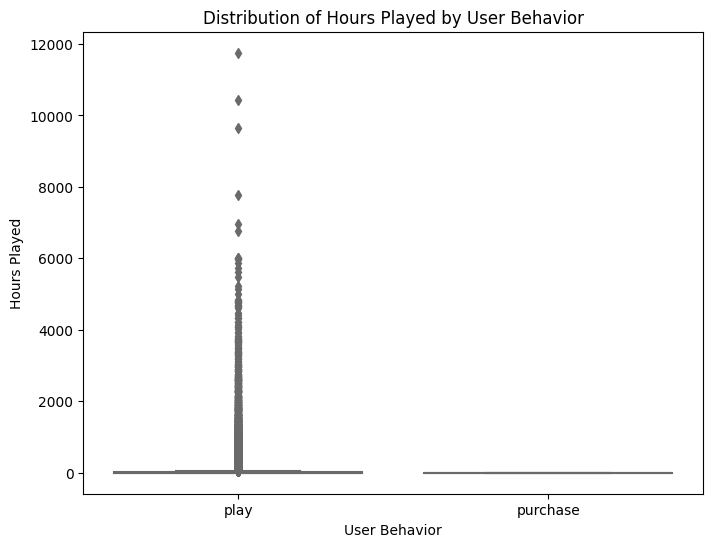

In [0]:
# Boxplot of Hours Played by User Behavior
plt.figure(figsize=(8, 6))
sns.boxplot(x='User_Behavior', y='Hours_Played', data=steam_df.toPandas(), palette='Set3')
plt.xlabel('User Behavior')
plt.ylabel('Hours Played')
plt.title('Distribution of Hours Played by User Behavior')
plt.show()


####  Preprocessing The Data

In [0]:
# Generating unique integer IDs for games based on game names

# Create a window specification
windowSpec = Window.orderBy("game_name")

# Add a row number column
game_id = steam_df.select('game_name').distinct().withColumn("game_id", F.row_number().over(windowSpec))


In [0]:
# Show the DataFrame with added game IDs
game_id.show(5)

+--------------------+-------+
|           game_name|game_id|
+--------------------+-------+
|         007 Legends|      1|
|           0RBITALIS|      2|
|1... 2... 3... KI...|      3|
|     10 Second Ninja|      4|
|          10,000,000|      5|
+--------------------+-------+
only showing top 5 rows



In [0]:
# Join the game IDs with the original DataFrame
steam_df_with_ids = steam_df.join(game_id, on='game_name', how='left')


# Print the schema of the DataFrame with added game IDs
steam_df_with_ids.printSchema()


root
 |-- game_name: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- User_Behavior: string (nullable = true)
 |-- Hours_Played: double (nullable = true)
 |-- game_id: integer (nullable = true)



In [0]:
# Handle missing values
training_data = steam_df_with_ids.na.drop(subset=["UserID", "game_id", "Hours_Played"])

In [0]:
# Preprocess data into correct format
preprocess = RFormula(formula="User_Behavior ~ .")
steam_df_with_ids = preprocess.fit(steam_df_with_ids).transform(steam_df_with_ids)
steam_df_with_ids.show(5)

2024/05/01 08:03:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '20f77dbf731741e6be45acded0ea3518', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


+--------------------+---------+-------------+------------+-------+--------------------+-----+
|           game_name|   UserID|User_Behavior|Hours_Played|game_id|            features|label|
+--------------------+---------+-------------+------------+-------+--------------------+-----+
|The Elder Scrolls...|151603712|         play|       273.0|   4365|(5157,[8,5154,515...|  1.0|
|           Fallout 4|151603712|     purchase|         1.0|   1679|(5157,[100,5154,5...|  0.0|
|           Fallout 4|151603712|         play|        87.0|   1679|(5157,[100,5154,5...|  1.0|
|               Spore|151603712|     purchase|         1.0|   3998|(5157,[332,5154,5...|  0.0|
|               Spore|151603712|         play|        14.9|   3998|(5157,[332,5154,5...|  1.0|
+--------------------+---------+-------------+------------+-------+--------------------+-----+
only showing top 5 rows



In [0]:
# Selecting Game name and ID for recommendation
game_rec =  steam_df_with_ids.select("game_name", "game_id")

In [0]:
# Filter the dataset to include only 'play' behavior
play_data = steam_df_with_ids.filter(steam_df_with_ids['User_Behavior'] == 'play')


In [0]:
# Checking for missing values
steam_df_with_ids.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for c in steam_df.columns]).show()


+------+---------+-------------+------------+
|UserID|game_name|User_Behavior|Hours_Played|
+------+---------+-------------+------------+
|     0|        0|            0|           0|
+------+---------+-------------+------------+



In [0]:
# Arrange in the correct format
play_data_format = play_data.select("UserID", "game_id", "Hours_Played")

In [0]:
# Calculate quartiles
quantiles = play_data_format.approxQuantile('Hours_Played', [0.25, 0.75], 0.05)
 
# Calculate IQR
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1
 
# Define lower and upper bounds for outlier detection
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
 
# Filter out rows outside the lower and upper bounds
steamplay_df_without_outliers = play_data_format.filter((col('Hours_Played') >= lower_bound) & (col('Hours_Played') <= upper_bound))
 
# Show the cleaned DataFrame
steamplay_df_without_outliers.show()


+---------+-------+------------+
|   UserID|game_id|Hours_Played|
+---------+-------+------------+
|151603712|   3998|        14.9|
|151603712|   1680|        12.1|
|151603712|   2476|         8.9|
|151603712|   2194|         8.5|
|151603712|   3115|         8.1|
|151603712|   3214|         7.5|
|151603712|   2475|         3.3|
|151603712|   4258|         2.8|
|151603712|   4645|         2.5|
|151603712|   4306|         2.0|
|151603712|   1141|         1.4|
|151603712|    523|         1.3|
|151603712|   1360|         1.3|
|151603712|   1675|         0.8|
|151603712|   3629|         0.8|
|151603712|   1977|         0.6|
|151603712|   3451|         0.5|
|151603712|   2657|         0.5|
|151603712|   1473|         0.5|
|151603712|   1337|         0.5|
+---------+-------+------------+
only showing top 20 rows



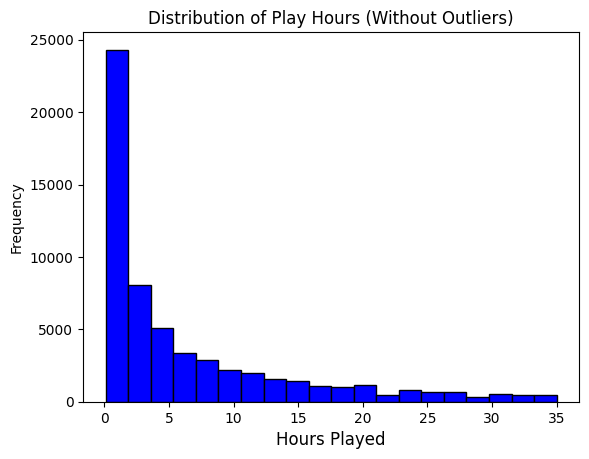

In [0]:
# Plot Histogram to show steamplay_df_without_outliers
plt.hist(steamplay_df_without_outliers.toPandas()['Hours_Played'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Hours Played', fontsize=12)
plt.ylabel('Frequency')
plt.title('Distribution of Play Hours (Without Outliers)')
plt.show()

#### Training the data set

In [0]:
# Split the data into training and testing sets (80% training, 20% test)
(training_data, testing_data) = steamplay_df_without_outliers.randomSplit([0.8, 0.2])

In [0]:
# Initialize the ALS model
als = ALS(maxIter=10, regParam=0.1, userCol="UserID", itemCol="game_id", ratingCol="Hours_Played", seed=100, nonnegative=True)

In [0]:
# Train the model
model = als.fit(training_data)

2024/05/01 08:04:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1e4abe3295ee4211a771ce7158dd1809', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 08:04:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Valu

In [0]:
# Make predictions on the testing data
predictions = model.transform(testing_data).dropna()

In [0]:
#Display Predictions
predictions.show()

+------+-------+------------+----------+
|UserID|game_id|Hours_Played|prediction|
+------+-------+------------+----------+
|  5250|   3224|        13.6|  8.064185|
| 76767|    728|        12.5|  20.73278|
|298950|     39|        14.3|  8.317608|
|298950|    183|         0.6| 2.5446677|
|298950|    480|         0.4| 6.9807954|
|298950|    679|         2.7| 2.2245302|
|298950|    833|        10.2| 12.944589|
|298950|    985|         0.5| 2.3128092|
|298950|   1289|        27.0|   9.71048|
|298950|   1326|         2.9|  4.260311|
|298950|   1406|         0.9| 3.0342512|
|298950|   1672|         0.3| 1.6095343|
|298950|   2345|         1.6|  6.789106|
|298950|   2435|         4.2| 6.0968165|
|298950|   2441|        10.8|  8.193081|
|298950|   2530|         2.3| 1.6198262|
|298950|   2652|         7.9|  5.073391|
|298950|   2713|         8.9| 6.2824025|
|298950|   3066|         3.4| 6.4815726|
|298950|   3744|         3.5|  5.794114|
+------+-------+------------+----------+
only showing top

In [0]:
# Evaluate the model using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))

Root Mean Squared Error (RMSE) = 9.305377292475214


In [0]:
# Evaluate the model using Cross-Validation

# Define the ALS model
als = ALS(maxIter=10, regParam=0.1, userCol="UserID", itemCol="game_id", ratingCol="Hours_Played", seed=100, nonnegative=True)

In [0]:
# Define the parameter grid for cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20, 30]) \
    .addGrid(als.regParam, [0.05, 0.1, 0.2]) \
    .build()

In [0]:
# Define the evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")

In [0]:
# Create cross-validator
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [0]:
# Fit the cross-validator to the training data
cvModel = crossval.fit(training_data)

2024/05/01 08:05:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '18bcc09cbd9e4c52997b7fb68be4ed35', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


In [0]:
# Make predictions on the testing data
predictions_cv = cvModel.transform(testing_data).dropna()

In [0]:
# Evaluate the model using RMSE
rmse_cv = evaluator.evaluate(predictions_cv)
print("Root Mean Squared Error (RMSE) after cross-validation = " + str(rmse_cv))


Root Mean Squared Error (RMSE) after cross-validation = 10.074126901607311


In [0]:
# Generate top n game recommendations for each user
userRecs = model.recommendForAllUsers(10)
userRecs.show(truncate=False)

+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|UserID  |recommendations                                                                                                                                                                                        |
+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|76767   |[{2941, 63.048588}, {1694, 51.1612}, {2369, 47.97747}, {4664, 46.659737}, {1692, 46.531}, {2734, 42.754284}, {358, 42.695145}, {1579, 42.420082}, {3849, 41.958847}, {973, 41.49283}]                  |
|144736  |[{2728, 0.24549845}, {1700, 0.24230993}, {1435, 0.22100864}, {3598, 0.21024448}, {3004, 0.20415668}, {2700, 0.20039433}, {3880, 0.19973885}, {1664

In [0]:
# Get recommendations for user with user_Id 1
user_id = 151603712
user_recommendations = userRecs.where(userRecs.UserID == user_id) \
                               .select("recommendations") \
                               .withColumn("recommendations", explode("recommendations")) \
                               .select("recommendations.game_id", "recommendations.rating") \
                               .join(game_rec, ["game_id"]) \
                               .show(truncate=False)

+-------+--------+---------------------------------+
|game_id|rating  |game_name                        |
+-------+--------+---------------------------------+
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multiplayer|
|736    |26.21401|Call of Duty Ghosts - Multip

In [0]:
# Parameter Tuning
import itertools

param_grid = {'maxIter': [5, 10, 15], 'regParam': [0.001, 0.005, 0.01, 0.05, 0.1]} 
best_rmse = float('inf')
best_params = None

for maxIter, regParam in itertools.product(param_grid['maxIter'], param_grid['regParam']):
    als = ALS(maxIter=maxIter, regParam=regParam, userCol='UserID', itemCol='game_id', ratingCol='Hours_Played', seed=100, nonnegative=True)
    model = als.fit(testing_data)
    predictions = model.transform(testing_data).dropna()
        
    # Evaluate model using RegressionEvaluator
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    print("RMSE for maxIter={}, regParam={}: {}".format(maxIter, regParam, rmse))
        
    # Update best RMSE and parameters if current RMSE is better
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (maxIter, regParam)

print("Best RMSE:", best_rmse)
print("Best Parameters:", best_params)


2024/05/01 07:11:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6b52839f74674253a6add4385f16e747', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:11:42 WARNING mlflow.pyspark.ml: Model ALS_f8ab15cd63ee will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.001: 1.155141943572359


2024/05/01 07:11:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2605e76ddf1f4b74880f720654035dda', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:12:06 WARNING mlflow.pyspark.ml: Model ALS_c5d1d736b646 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.005: 1.0827336355763257


2024/05/01 07:12:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0c959415d2014619883f4352a26145aa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:12:30 WARNING mlflow.pyspark.ml: Model ALS_a3e4c5ca55c9 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.01: 1.0559850958487755


2024/05/01 07:12:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9171a8fcb8b34cb98d25452088437d9a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:12:55 WARNING mlflow.pyspark.ml: Model ALS_f3eac9adc464 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.05: 1.05022630921741


2024/05/01 07:13:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b370baba6e634db6ab30886e30b5d189', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:13:21 WARNING mlflow.pyspark.ml: Model ALS_009e6de14ced will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.1: 1.0652647298695588


2024/05/01 07:13:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3fb98d39be4442bb80e56c272e5c96ae', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:13:58 WARNING mlflow.pyspark.ml: Model ALS_567473319745 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.001: 0.8181112192283247


2024/05/01 07:14:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '876c7c94ebe34943b7a528eed58cfd44', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:14:37 WARNING mlflow.pyspark.ml: Model ALS_e26f60067bf6 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.005: 0.795570456950114


2024/05/01 07:14:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3a46a08a92b94dcbab2b49226308b1a7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:15:15 WARNING mlflow.pyspark.ml: Model ALS_c7faa501a5ab will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.01: 0.7633439375030845


2024/05/01 07:15:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cc1ed58e11dc4993b676f25ad6255f4d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:15:54 WARNING mlflow.pyspark.ml: Model ALS_9bd82db94b6d will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.05: 0.7464905628019093


2024/05/01 07:16:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3796b254e3694475a0fd1c0c30c41752', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:16:33 WARNING mlflow.pyspark.ml: Model ALS_b09d79f4ab7b will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.1: 0.7918807675436655


2024/05/01 07:16:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a7c1481225054dfc8f6d8f43aeb915fe', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:17:35 WARNING mlflow.pyspark.ml: Model ALS_ff9a48596db4 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.001: 0.6797514058732762


2024/05/01 07:17:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a34cd5681fc947f1b67cb50f57835770', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:18:41 WARNING mlflow.pyspark.ml: Model ALS_8c72f38e7b6c will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.005: 0.6674627759036287


2024/05/01 07:18:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8c0adb9e35104f96939e8dc9a87d14f6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:19:45 WARNING mlflow.pyspark.ml: Model ALS_cc4b330e3a98 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.01: 0.6316299617513097


2024/05/01 07:19:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dabb7e0640764b4e98d3f13d39707835', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:20:51 WARNING mlflow.pyspark.ml: Model ALS_75df01439c63 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.05: 0.6259637470015738


2024/05/01 07:21:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3fb2b756b3b24398ae95b7918b71d2b4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:21:56 WARNING mlflow.pyspark.ml: Model ALS_3c2fa7f0f2b3 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.1: 0.6845810997896209
Best RMSE: 0.6259637470015738
Best Parameters: (15, 0.05)


2024/05/01 07:22:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'acf8cb77931f407dabcfd118ffdf5666', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:22:25 WARNING mlflow.pyspark.ml: Model ALS_ca99ac6cc820 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.001: 1.155141943572359


2024/05/01 07:22:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5ce8c67f4e2d421f97fb3e6e45873dae', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:22:48 WARNING mlflow.pyspark.ml: Model ALS_51f0790af31c will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.005: 1.0827336355763257


2024/05/01 07:22:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1e3337c71a214837ad42a62cb9852d0b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:23:11 WARNING mlflow.pyspark.ml: Model ALS_1c9117bc9339 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.01: 1.0559850958487755


2024/05/01 07:23:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5e6a67f6a4024cfd86583b63c838f6ae', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:23:34 WARNING mlflow.pyspark.ml: Model ALS_a4b84b01edcc will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.05: 1.05022630921741


2024/05/01 07:23:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '32a96c76acba4347bba805eb226ca5ef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:23:57 WARNING mlflow.pyspark.ml: Model ALS_55c4ca9d032e will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.1: 1.0652647298695588


2024/05/01 07:24:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'debf4bb8547e47f6bcc3cd604048e63e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:24:34 WARNING mlflow.pyspark.ml: Model ALS_663ab5970658 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.001: 0.8181112192283247


2024/05/01 07:24:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '29af4c30249c4124a7df21affcd60a09', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:25:12 WARNING mlflow.pyspark.ml: Model ALS_e841003274b0 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.005: 0.795570456950114


2024/05/01 07:25:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '61eb6c88c12b4127adc4b88975ab4c6b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:25:50 WARNING mlflow.pyspark.ml: Model ALS_adfcc41192c3 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.01: 0.7633439375030845


2024/05/01 07:26:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f6f511a584da4450a3b77528da194a8a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:26:29 WARNING mlflow.pyspark.ml: Model ALS_1c60acb46c6f will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.05: 0.7464905628019093


2024/05/01 07:26:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '09f94665d98a4c87a0a6ae7135183f5c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:27:07 WARNING mlflow.pyspark.ml: Model ALS_43093948be99 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.1: 0.7918807675436655


2024/05/01 07:27:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f5bd431d50a34144b5638d54ec319d72', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:28:09 WARNING mlflow.pyspark.ml: Model ALS_325a40cdfe0c will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.001: 0.6797514058732762


2024/05/01 07:28:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8e48e7c6417b4aaa9ad7077d6019798a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:29:13 WARNING mlflow.pyspark.ml: Model ALS_e2959a9d10e4 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.005: 0.6674627759036287


2024/05/01 07:29:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4409a98b45a5454898924ea018044500', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:30:18 WARNING mlflow.pyspark.ml: Model ALS_922f723a7ab2 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.01: 0.6316299617513097


2024/05/01 07:30:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3140a547e1df41ab8fcb954c19ace45b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:31:22 WARNING mlflow.pyspark.ml: Model ALS_54bff3a02a23 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.05: 0.6259637470015738


2024/05/01 07:31:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2e0b4d51bb644d5a8bba4bfb893281fa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 07:32:28 WARNING mlflow.pyspark.ml: Model ALS_c86198f461b3 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.1: 0.6845810997896209


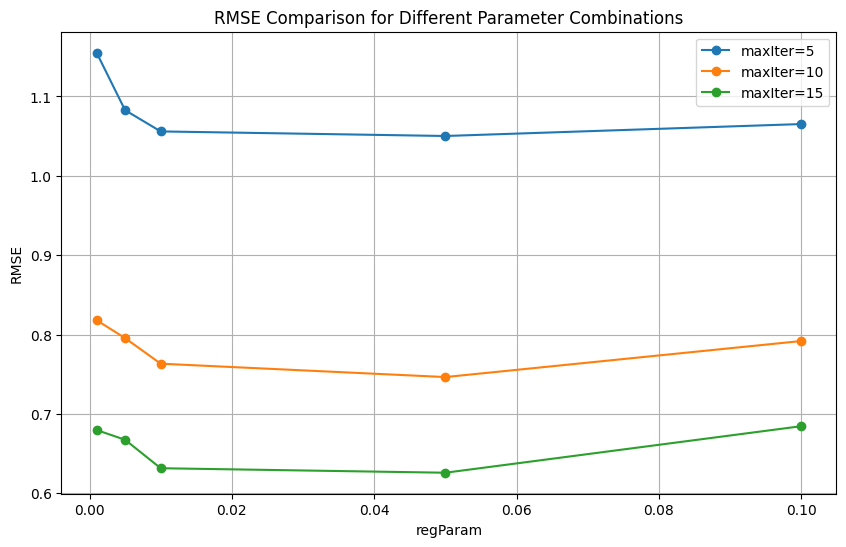

In [0]:
# Parameter Tuning With plotting
param_grid = {'maxIter': [5, 10, 15], 'regParam': [0.001, 0.005, 0.01, 0.05, 0.1]} 
rmse_values = []

for maxIter in param_grid['maxIter']:
    for regParam in param_grid['regParam']:
        als = ALS(maxIter=maxIter, regParam=regParam, userCol='UserID', itemCol='game_id', ratingCol='Hours_Played', seed=100, nonnegative=True)
        model = als.fit(testing_data)
        predictions = model.transform(testing_data).dropna()
        
        # Evaluate model using RegressionEvaluator
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")
        rmse = evaluator.evaluate(predictions)
        print("RMSE for maxIter={}, regParam={}: {}".format(maxIter, regParam, rmse))
        
        # Append RMSE value to the list
        rmse_values.append((maxIter, regParam, rmse))

# Convert list of tuples to a DataFrame
rmse_df = pd.DataFrame(rmse_values, columns=['maxIter', 'regParam', 'RMSE'])

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
for maxIter in param_grid['maxIter']:
    subset = rmse_df[rmse_df['maxIter'] == maxIter]
    plt.plot(subset['regParam'], subset['RMSE'], marker='o', label=f'maxIter={maxIter}')

plt.title('RMSE Comparison for Different Parameter Combinations')
plt.xlabel('regParam')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()
